In [ ]:
# Install split-folders (used only if your zip doesn't already have train/val/test)
!pip install -q split-folders
!pip install -q seaborn


In [ ]:
# Standard imports used throughout the notebook
import os, zipfile, glob, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger


In [ ]:
import zipfile

zip_path = "/content/Dataset.zip"

try:
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.testzip()
        print("✅ ZIP file is valid")
except zipfile.BadZipFile:
    print("❌ Bad ZIP file - corrupted or not a ZIP")



✅ ZIP file is valid


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.listdir()


['.config', 'drive', 'Dataset.zip', 'sample_data']

In [ ]:
import zipfile

zip_path = "/content/Dataset.zip"  # uploaded file path
extract_path = "/content/fish_dataset"

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Extracted to:", extract_path)


Extracted to: /content/fish_dataset


In [ ]:
import os

# Look at the top-level folders after extraction
for root, dirs, files in os.walk("/content/fish_dataset"):
    level = root.replace("/content/fish_dataset", "").count(os.sep)
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/ - {len(dirs)} folders, {len(files)} files")
    if level >= 2:  # stop after showing a few levels deep
        break


fish_dataset/ - 1 folders, 0 files
  images.cv_jzk6llhf18tm3k0kyttxz/ - 1 folders, 1 files
    data/ - 3 folders, 0 files


In [ ]:
import splitfolders

def find_class_root(root):
    IMAGE_EXT = ('.jpg', '.jpeg', '.png')
    # Traverse up to 5 levels deep to find the class root
    for dirpath, dirnames, filenames in os.walk(root):
        level = dirpath.replace(root, "").count(os.sep)
        if level > 5:
            continue

        # Check if any subdirectories contain image files
        for dirname in dirnames:
            subdir_path = os.path.join(dirpath, dirname)
            try:
                # Check if the subdirectory contains subdirectories (potential classes)
                subdirs_of_subdir = [d for d in os.listdir(subdir_path) if os.path.isdir(os.path.join(subdir_path, d))]
                if not subdirs_of_subdir:
                    continue

                # Check if any of the sub-subdirectories contain image files
                for subsubdir in subdirs_of_subdir:
                    subsubdir_path = os.path.join(subdir_path, subsubdir)
                    imgs = [f for f in os.listdir(subsubdir_path) if f.lower().endswith(IMAGE_EXT)]
                    if imgs:
                        return subdir_path # Return the directory containing the class folders
            except OSError:
                # Handle cases where listing directory contents fails
                continue
    return None

def has_train_val_test(root):
    return all(os.path.isdir(os.path.join(root, s)) for s in ['train', 'val', 'test'])

dataset_root = "/content/fish_dataset"
class_root = find_class_root(dataset_root)

if class_root is None:
    print("❌ Could not find the directory containing image classes.")
elif has_train_val_test(dataset_root):
    train_dir = os.path.join(dataset_root, 'train')
    val_dir   = os.path.join(dataset_root, 'val')
    test_dir  = os.path.join(dataset_root, 'test')
    print("✅ Found train/val/test folders already.")
else:
    print("ℹ No split found — creating 70/15/15 split...")
    output_dir = "/content/fish_dataset_split"
    splitfolders.ratio(class_root, output=output_dir, seed=42, ratio=(0.7, 0.15, 0.15))
    train_dir = os.path.join(output_dir, 'train')
    val_dir   = os.path.join(output_dir, 'val')
    test_dir  = os.path.join(output_dir, 'test')

print("Train folder:", train_dir)
print("Val folder  :", val_dir)
print("Test folder :", test_dir)

ℹ No split found — creating 70/15/15 split...


Copying files: 1092 files [00:00, 5694.18 files/s]

Train folder: /content/fish_dataset_split/train
Val folder  : /content/fish_dataset_split/val
Test folder : /content/fish_dataset_split/test


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "/content/fish_dataset_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    "/content/fish_dataset_split/val",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    "/content/fish_dataset_split/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print("✅ Number of classes:", num_classes)
print("📌 Class mapping:", train_gen.class_indices)


Found 758 images belonging to 11 classes.
Found 159 images belonging to 11 classes.
Found 175 images belonging to 11 classes.
✅ Number of classes: 11
📌 Class mapping: {'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

# 1️⃣ Build CNN architecture
def build_cnn(input_shape=(224,224,3), n_classes=2):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D(2)(x)

    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(n_classes, activation='softmax')(x)

    return Model(inputs, outputs)

# 2️⃣ Create model
cnn_model = build_cnn(input_shape=(224,224,3), n_classes=num_classes)

# 3️⃣ Compile model
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4️⃣ Training callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

callbacks = [
    ModelCheckpoint("cnn_scratch_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# 5️⃣ Train the model
EPOCHS = 10  # Increase if GPU allows
history_cnn = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)

# 6️⃣ Save final model
cnn_model.save("cnn_scratch_final.h5")
print("✅ CNN model saved as cnn_scratch_final.h5")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0981 - loss: 2.3923
Epoch 1: val_accuracy improved from -inf to 0.17610, saving model to cnn_scratch_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 133s 5s/step - accuracy: 0.0986 - loss: 2.3920 - val_accuracy: 0.1761 - val_loss: 2.3574 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1754 - loss: 2.3536
Epoch 2: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - accuracy: 0.1753 - loss: 2.3531 - val_accuracy: 0.1761 - val_loss: 2.3014 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1813 - loss: 2.3174
Epoch 3: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 129s 5s/step - accuracy: 0.1809 - loss: 2.3179 - val_accuracy: 0.1761 - val_loss: 2.2893 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1671 - loss: 2.3073
Epoch 4: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.1673 - loss: 2.3072 - val_accuracy: 0.1761 - val_loss: 2.2667 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━

✅ CNN model saved as cnn_scratch_final.h5


6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.3430 - loss: 2.3245
✅ Test Accuracy: 0.1657
✅ Test Loss: 2.3604
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step

📊 Classification Report:

                                  precision    recall  f1-score   support

                     animal fish       0.17      1.00      0.28        29
                animal fish bass       0.00      0.00      0.00         2
   fish sea_food black_sea_sprat       0.00      0.00      0.00        17
   fish sea_food gilt_head_bream       0.00      0.00      0.00        15
   fish sea_food hourse_mackerel       0.00      0.00      0.00        16
        fish sea_food red_mullet       0.00      0.00      0.00        15
     fish sea_food red_sea_bream       0.00      0.00      0.00        18
          fish sea_food sea_bass       0.00      0.00      0.00        16
            fish sea_food shrimp       0.00      0.00      0.00        15
fish sea_food striped_red_mullet       0.00      0.00      0.00        16
        

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


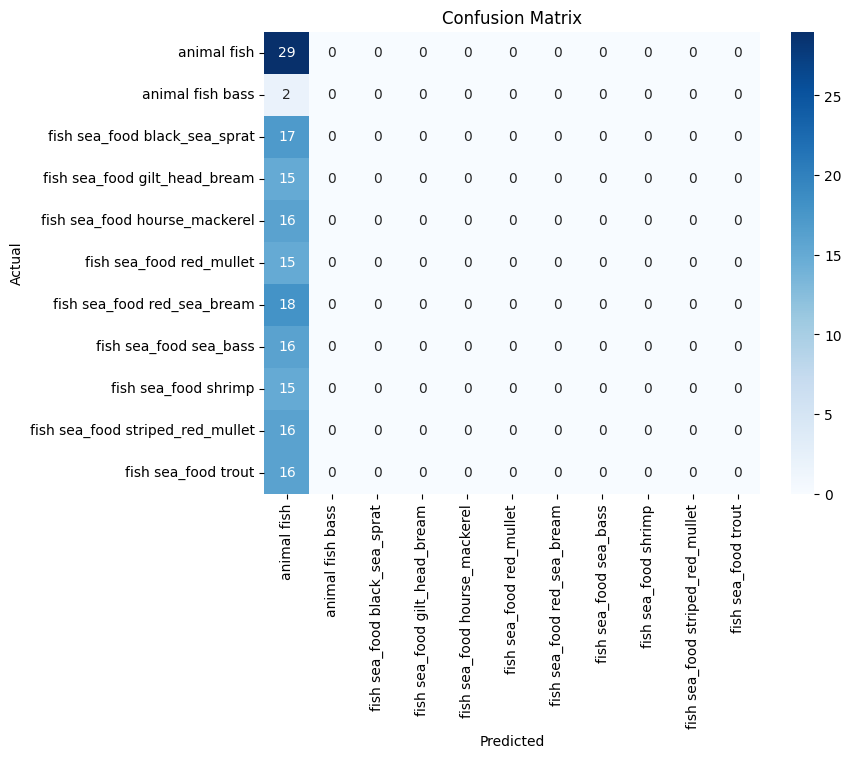

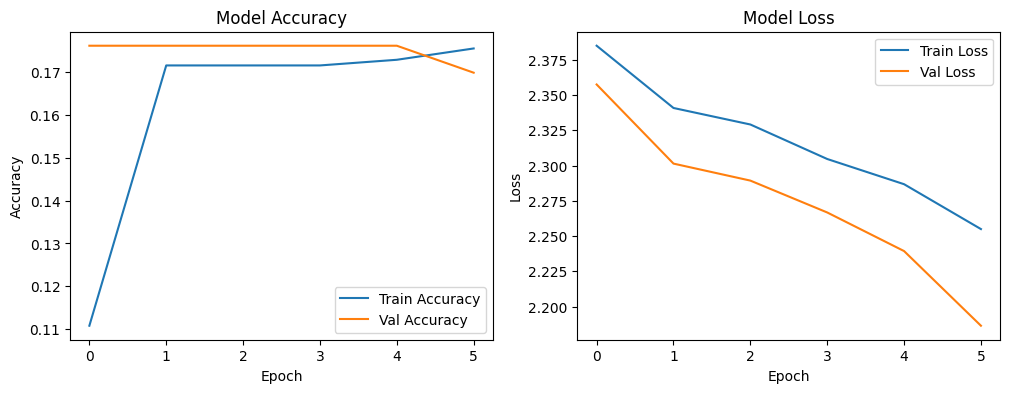

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Evaluate on test data
test_loss, test_acc = cnn_model.evaluate(test_gen, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")

# 2️⃣ Predictions
y_pred_probs = cnn_model.predict(test_gen)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# 3️⃣ FIXED Classification report
# Only include labels actually present in y_true
unique_classes = np.unique(y_true)
labels = list(unique_classes)
target_names = [class_labels[i] for i in labels]

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, labels=labels, target_names=target_names))

# 4️⃣ Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes, labels=labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 5️⃣ Training history visualization
plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()






In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

pretrained_models = {
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "MobileNetV2": MobileNetV2,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0
}

transfer_results = {}

# Get the number of classes from the train generator
num_classes = len(train_gen.class_indices)


for model_name, model_class in pretrained_models.items():
    print(f"\n🔹 Training with {model_name}...")

    # 1️⃣ Load base model without top layer
    base_model = model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False  # Freeze base layers initially

    # 2️⃣ Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # 3️⃣ Compile model
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # 4️⃣ Callbacks
    checkpoint = ModelCheckpoint(f"{model_name}_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    # 5️⃣ Train model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,  # Can increase if GPU allows
        callbacks=[checkpoint, early_stop, reduce_lr],
        verbose=1
    )

    # 6️⃣ Evaluate on test set
    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    transfer_results[model_name] = {"Test Accuracy": test_acc, "Test Loss": test_loss}

    # Save final model
    model.save(f"{model_name}_final.h5")
    print(f"✅ {model_name} completed — Test Accuracy: {test_acc:.4f}")

# 📊 Show all results
import pandas as pd
results_df = pd.DataFrame(transfer_results).T
print("\n📊 Transfer Learning Results:\n", results_df)


🔹 Training with VGG16...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.0805 - loss: 2.6367 
Epoch 1: val_accuracy improved from -inf to 0.23270, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 583s 24s/step - accuracy: 0.0806 - loss: 2.6352 - val_accuracy: 0.2327 - val_loss: 2.3413 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.1217 - loss: 2.4789 
Epoch 2: val_accuracy improved from 0.23270 to 0.23899, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 613s 26s/step - accuracy: 0.1225 - loss: 2.4775 - val_accuracy: 0.2390 - val_loss: 2.2459 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.1699 - loss: 2.4036 
Epoch 3: val_accuracy did not improve from 0.23899
24/24 ━━━━━━━━━━━━━━━━━━━━ 576s 24s/step - accuracy: 0.1696 - loss: 2.4028 - val_accuracy: 0.2201 - val_loss: 2.1890 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2110 - loss: 2.2944 
Epoch 4: val_accuracy improved from 0.23899 to 0.32075, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 566s 24s/step - accuracy: 0.2110 - loss: 2.2945 - val_accuracy: 0.3208 - val_loss: 2.1386 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2410 - loss: 2.2260 
Epoch 5: val_accuracy improved from 0.32075 to 0.33962, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 566s 24s/step - accuracy: 0.2400 - loss: 2.2268 - val_accuracy: 0.3396 - val_loss: 2.0975 - learning_rate: 1.0000e-04
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2181 - loss: 2.2111 
Epoch 6: val_accuracy improved from 0.33962 to 0.35220, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 615s 26s/step - accuracy: 0.2185 - loss: 2.2115 - val_accuracy: 0.3522 - val_loss: 2.0635 - learning_rate: 1.0000e-04
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2370 - loss: 2.1588 
Epoch 7: val_accuracy improved from 0.35220 to 0.40252, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 577s 24s/step - accuracy: 0.2372 - loss: 2.1589 - val_accuracy: 0.4025 - val_loss: 2.0288 - learning_rate: 1.0000e-04
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2690 - loss: 2.1364 
Epoch 8: val_accuracy improved from 0.40252 to 0.45912, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 568s 24s/step - accuracy: 0.2691 - loss: 2.1355 - val_accuracy: 0.4591 - val_loss: 1.9988 - learning_rate: 1.0000e-04
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2640 - loss: 2.1154 
Epoch 9: val_accuracy improved from 0.45912 to 0.52201, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 571s 24s/step - accuracy: 0.2646 - loss: 2.1136 - val_accuracy: 0.5220 - val_loss: 1.9659 - learning_rate: 1.0000e-04
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2613 - loss: 2.0691 
Epoch 10: val_accuracy improved from 0.52201 to 0.54717, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 568s 24s/step - accuracy: 0.2621 - loss: 2.0682 - val_accuracy: 0.5472 - val_loss: 1.9339 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


✅ VGG16 completed — Test Accuracy: 0.4914

🔹 Training with ResNet50...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1262 - loss: 2.9474
Epoch 1: val_accuracy improved from -inf to 0.17610, saving model to ResNet50_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 187s 8s/step - accuracy: 0.1257 - loss: 2.9409 - val_accuracy: 0.1761 - val_loss: 2.3284 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1116 - loss: 2.5923
Epoch 2: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 196s 7s/step - accuracy: 0.1119 - loss: 2.5898 - val_accuracy: 0.1761 - val_loss: 2.2901 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1344 - loss: 2.4523
Epoch 3: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 174s 7s/step - accuracy: 0.1336 - loss: 2.4536 - val_accuracy: 0.1761 - val_loss: 2.2804 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1409 - loss: 2.4468
Epoch 4: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 187s 8s/step - accuracy: 0.1407 - loss: 2.4460 - val_accuracy: 0.1761 - val_loss: 2.2737 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━

✅ ResNet50 completed — Test Accuracy: 0.1657

🔹 Training with MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1052 - loss: 2.7656
Epoch 1: val_accuracy improved from -inf to 0.42138, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.1069 - loss: 2.7570 - val_accuracy: 0.4214 - val_loss: 1.8477 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3278 - loss: 1.9743
Epoch 2: val_accuracy improved from 0.42138 to 0.60377, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.3293 - loss: 1.9698 - val_accuracy: 0.6038 - val_loss: 1.4441 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4947 - loss: 1.5669
Epoch 3: val_accuracy improved from 0.60377 to 0.74843, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4955 - loss: 1.5652 - val_accuracy: 0.7484 - val_loss: 1.1537 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6127 - loss: 1.2630
Epoch 4: val_accuracy improved from 0.74843 to 0.82390, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.6125 - loss: 1.2619 - val_accuracy: 0.8239 - val_loss: 0.9490 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7150 - loss: 1.0025
Epoch 5: val_accuracy improved from 0.82390 to 0.86792, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7141 - loss: 1.0036 - val_accuracy: 0.8679 - val_loss: 0.7988 - learning_rate: 1.0000e-04
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6960 - loss: 0.9633
Epoch 6: val_accuracy improved from 0.86792 to 0.88679, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6963 - loss: 0.9626 - val_accuracy: 0.8868 - val_loss: 0.6815 - learning_rate: 1.0000e-04
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7131 - loss: 0.9276
Epoch 7: val_accuracy improved from 0.88679 to 0.91195, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.7139 - loss: 0.9250 - val_accuracy: 0.9119 - val_loss: 0.6042 - learning_rate: 1.0000e-04
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7780 - loss: 0.7905
Epoch 8: val_accuracy improved from 0.91195 to 0.91824, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.7777 - loss: 0.7895 - val_accuracy: 0.9182 - val_loss: 0.5414 - learning_rate: 1.0000e-04
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7963 - loss: 0.7429
Epoch 9: val_accuracy improved from 0.91824 to 0.92453, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.7965 - loss: 0.7416 - val_accuracy: 0.9245 - val_loss: 0.4850 - learning_rate: 1.0000e-04
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8484 - loss: 0.6023
Epoch 10: val_accuracy improved from 0.92453 to 0.94340, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8479 - loss: 0.6032 - val_accuracy: 0.9434 - val_loss: 0.4434 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


✅ MobileNetV2 completed — Test Accuracy: 0.9143

🔹 Training with InceptionV3...
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1050 - loss: 2.9179
Epoch 1: val_accuracy improved from -inf to 0.42138, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - accuracy: 0.1076 - loss: 2.9035 - val_accuracy: 0.4214 - val_loss: 1.8087 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3168 - loss: 1.8823
Epoch 2: val_accuracy improved from 0.42138 to 0.67925, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 137s 5s/step - accuracy: 0.3192 - loss: 1.8770 - val_accuracy: 0.6792 - val_loss: 1.3564 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5268 - loss: 1.4263
Epoch 3: val_accuracy improved from 0.67925 to 0.73585, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 138s 5s/step - accuracy: 0.5267 - loss: 1.4255 - val_accuracy: 0.7358 - val_loss: 1.0944 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6293 - loss: 1.2190
Epoch 4: val_accuracy improved from 0.73585 to 0.77987, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.6299 - loss: 1.2174 - val_accuracy: 0.7799 - val_loss: 0.9339 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6115 - loss: 1.1427
Epoch 5: val_accuracy improved from 0.77987 to 0.78616, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.6131 - loss: 1.1384 - val_accuracy: 0.7862 - val_loss: 0.7866 - learning_rate: 1.0000e-04
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7083 - loss: 0.9248
Epoch 6: val_accuracy improved from 0.78616 to 0.87421, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 128s 5s/step - accuracy: 0.7082 - loss: 0.9241 - val_accuracy: 0.8742 - val_loss: 0.6784 - learning_rate: 1.0000e-04
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7028 - loss: 0.9466
Epoch 7: val_accuracy improved from 0.87421 to 0.88050, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.7044 - loss: 0.9421 - val_accuracy: 0.8805 - val_loss: 0.6182 - learning_rate: 1.0000e-04
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7344 - loss: 0.7740
Epoch 8: val_accuracy did not improve from 0.88050
24/24 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.7353 - loss: 0.7729 - val_accuracy: 0.8616 - val_loss: 0.5771 - learning_rate: 1.0000e-04
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7887 - loss: 0.7087
Epoch 9: val_accuracy did not improve from 0.88050
24/24 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.7888 - loss: 0.7085 - val_accuracy: 0.8616 - val_loss: 0.5296 - learning_rate: 1.0000e-04
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8194 - loss: 0.6504
Epoch 10: val_accuracy did not improve from 0.88050
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.8193 - loss: 0.6501 - val_accuracy: 0.8742 - val_loss: 0.4941 - learning_rate: 1.0000e-04
Restoring model weig

✅ InceptionV3 completed — Test Accuracy: 0.8629

🔹 Training with EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1092 - loss: 2.4006
Epoch 1: val_accuracy improved from -inf to 0.17610, saving model to EfficientNetB0_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 99s 3s/step - accuracy: 0.1102 - loss: 2.3994 - val_accuracy: 0.1761 - val_loss: 2.3143 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1723 - loss: 2.3286
Epoch 2: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.1721 - loss: 2.3291 - val_accuracy: 0.1761 - val_loss: 2.3087 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1553 - loss: 2.3474
Epoch 3: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.1549 - loss: 2.3477 - val_accuracy: 0.1761 - val_loss: 2.3091 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1714 - loss: 2.3413
Epoch 4: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.1711 - loss: 2.3414 - val_accuracy: 0.1761 - val_loss: 2.3069 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━━━━━

✅ EfficientNetB0 completed — Test Accuracy: 0.1657

📊 Transfer Learning Results:
                 Test Accuracy  Test Loss
VGG16                0.491429   1.939935
ResNet50             0.165714   2.337250
MobileNetV2          0.914286   0.440947
InceptionV3          0.862857   0.603301
EfficientNetB0       0.165714   2.327034


In [ ]:
# Replace these with your actual class names from your dataset
class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5',
               'Class6', 'Class7', 'Class8', 'Class9', 'Class10', 'Class11']

app_code = f"""
import streamlit as st
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from PIL import Image

# Load model
MODEL_PATH = "MobileNetV2_best.h5"
model = tf.keras.models.load_model(MODEL_PATH)

# Class names
class_names = {class_names}

# App title
st.title("🐟 Multiclass Fish Image Classification")
st.write("Upload a fish image and get instant prediction with confidence scores.")

# File uploader
uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    img = Image.open(uploaded_file).convert("RGB")
    st.image(img, caption="Uploaded Image", use_column_width=True)

    # Preprocess image
    img = img.resize((224, 224))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediction
    preds = model.predict(img_array)
    predicted_class = np.argmax(preds[0])
    confidence = np.max(preds[0]) * 100

    st.write(f"**Prediction:** {{class_names[predicted_class]}}")
    st.write(f"**Confidence:** {{confidence:.2f}}%")
"""

with open("app.py", "w") as f:
    f.write(app_code)

print("✅ app.py created")



✅ app.py created


In [ ]:
import gdown
if not os.path.exists("MobileNetV2_best.h5"):
    gdown.download("https://drive.google.com/uc?id=YOUR_FILE_ID", "MobileNetV2_best.h5", quiet=False)


In [ ]:
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd

transfer_results = {}
histories = {}

labels = list(train_gen.class_indices.keys())
num_classes = len(labels)
os.makedirs("reports", exist_ok=True)

# =======================
# 1️⃣ CNN FROM SCRATCH
# =======================
print("\n🔹 Training CNN from scratch...")

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("cnn_scratch_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_cnn = cnn_model.fit(train_gen, validation_data=val_gen, epochs=10,
                            callbacks=[checkpoint, early_stop, reduce_lr], verbose=1)
histories["CNN_Scratch"] = history_cnn

test_loss, test_acc = cnn_model.evaluate(test_gen, verbose=0)
transfer_results["CNN_Scratch"] = {"Test Accuracy": round(test_acc*100, 2), "Test Loss": round(test_loss, 4)}
cnn_model.save("cnn_scratch_final.h5")
print(f"✅ CNN Scratch completed — Test Accuracy: {test_acc:.4f}")

# Confusion Matrix + Curves
y_true = test_gen.classes
y_pred = np.argmax(cnn_model.predict(test_gen), axis=1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - CNN_Scratch")
plt.savefig("reports/confusion_matrix_CNN_Scratch.png")
plt.close()

plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Curve - CNN_Scratch")
plt.legend()
plt.savefig("reports/accuracy_curve_CNN_Scratch.png")
plt.close()

plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title("Loss Curve - CNN_Scratch")
plt.legend()
plt.savefig("reports/loss_curve_CNN_Scratch.png")
plt.close()

# =======================
# 2️⃣ PRETRAINED MODELS
# =======================
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2, InceptionV3, EfficientNetB0

pretrained_models = {
    "VGG16": VGG16,
    "ResNet50": ResNet50,
    "MobileNetV2": MobileNetV2,
    "InceptionV3": InceptionV3,
    "EfficientNetB0": EfficientNetB0
}

for model_name, model_class in pretrained_models.items():
    print(f"\n🔹 Training with {model_name}...")

    base_model = model_class(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    checkpoint = ModelCheckpoint(f"{model_name}_best.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
    early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

    history = model.fit(train_gen, validation_data=val_gen, epochs=10,
                        callbacks=[checkpoint, early_stop, reduce_lr], verbose=1)

    histories[model_name] = history

    test_loss, test_acc = model.evaluate(test_gen, verbose=0)
    transfer_results[model_name] = {"Test Accuracy": round(test_acc*100, 2), "Test Loss": round(test_loss, 4)}
    model.save(f"{model_name}_final.h5")
    print(f"✅ {model_name} completed — Test Accuracy: {test_acc:.4f}")

    y_pred = np.argmax(model.predict(test_gen), axis=1)
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f"reports/confusion_matrix_{model_name}.png")
    plt.close()

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f"Accuracy Curve - {model_name}")
    plt.legend()
    plt.savefig(f"reports/accuracy_curve_{model_name}.png")
    plt.close()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"Loss Curve - {model_name}")
    plt.legend()
    plt.savefig(f"reports/loss_curve_{model_name}.png")
    plt.close()

# =======================
# 3️⃣ SAVE MODEL COMPARISON
# =======================
results_df = pd.DataFrame(transfer_results).T
results_df.to_csv("model_comparison.csv")
results_df.to_csv("reports/model_comparison.csv")
print("\n📊 Model Comparison:\n", results_df)

# =======================
# 4️⃣ ZIP & DOWNLOAD
# =======================
import shutil
shutil.make_archive("reports", 'zip', "reports")

from google.colab import files
files.download("reports.zip")
files.download("model_comparison.csv")



🔹 Training CNN from scratch...
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1361 - loss: 2.3460
Epoch 1: val_accuracy improved from -inf to 0.18868, saving model to cnn_scratch_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 115s 5s/step - accuracy: 0.1372 - loss: 2.3451 - val_accuracy: 0.1887 - val_loss: 2.2092 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2341 - loss: 2.1949
Epoch 2: val_accuracy improved from 0.18868 to 0.35220, saving model to cnn_scratch_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.2339 - loss: 2.1943 - val_accuracy: 0.3522 - val_loss: 1.9913 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3082 - loss: 2.0447
Epoch 3: val_accuracy improved from 0.35220 to 0.45912, saving model to cnn_scratch_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.3090 - loss: 2.0418 - val_accuracy: 0.4591 - val_loss: 1.7746 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3274 - loss: 1.9391
Epoch 4: val_accuracy improved from 0.45912 to 0.50943, saving model to cnn_scratch_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 107s 4s/step - accuracy: 0.3279 - loss: 1.9370 - val_accuracy: 0.5094 - val_loss: 1.6665 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3623 - loss: 1.8296
Epoch 5: val_accuracy did not improve from 0.50943
24/24 ━━━━━━━━━━━━━━━━━━━━ 139s 4s/step - accuracy: 0.3629 - loss: 1.8263 - val_accuracy: 0.4969 - val_loss: 1.5566 - learning_rate: 1.0000e-04
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4175 - loss: 1.7136
Epoch 6: val_accuracy improved from 0.50943 to 0.54088, saving model to cnn_scratch_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - accuracy: 0.4183 - loss: 1.7115 - val_accuracy: 0.5409 - val_loss: 1.4971 - learning_rate: 1.0000e-04
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4540 - loss: 1.6084
Epoch 7: val_accuracy improved from 0.54088 to 0.61006, saving model to cnn_scratch_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 118s 5s/step - accuracy: 0.4543 - loss: 1.6075 - val_accuracy: 0.6101 - val_loss: 1.4144 - learning_rate: 1.0000e-04
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5093 - loss: 1.4452
Epoch 8: val_accuracy did not improve from 0.61006
24/24 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - accuracy: 0.5088 - loss: 1.4471 - val_accuracy: 0.5660 - val_loss: 1.3782 - learning_rate: 1.0000e-04
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5018 - loss: 1.4577
Epoch 9: val_accuracy did not improve from 0.61006
24/24 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.5016 - loss: 1.4594 - val_accuracy: 0.5912 - val_loss: 1.3199 - learning_rate: 1.0000e-04
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5151 - loss: 1.4404
Epoch 10: val_accuracy did not improve from 0.61006
24/24 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.5155 - loss: 1.4396 - val_accuracy: 0.5723 - val_loss: 1.3685 - learning_rate: 1.0000e-04
Restoring model weig

✅ CNN Scratch completed — Test Accuracy: 0.5486
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step

🔹 Training with VGG16...
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.1008 - loss: 2.5797 
Epoch 1: val_accuracy improved from -inf to 0.17610, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 589s 25s/step - accuracy: 0.1015 - loss: 2.5789 - val_accuracy: 0.1761 - val_loss: 2.3303 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.1252 - loss: 2.4496 
Epoch 2: val_accuracy improved from 0.17610 to 0.18868, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 590s 25s/step - accuracy: 0.1262 - loss: 2.4490 - val_accuracy: 0.1887 - val_loss: 2.2607 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.1737 - loss: 2.3986 
Epoch 3: val_accuracy improved from 0.18868 to 0.20126, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 577s 24s/step - accuracy: 0.1737 - loss: 2.3972 - val_accuracy: 0.2013 - val_loss: 2.2065 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.1727 - loss: 2.3883 
Epoch 4: val_accuracy improved from 0.20126 to 0.23270, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 616s 26s/step - accuracy: 0.1734 - loss: 2.3866 - val_accuracy: 0.2327 - val_loss: 2.1618 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2541 - loss: 2.1948 
Epoch 5: val_accuracy improved from 0.23270 to 0.26415, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 576s 24s/step - accuracy: 0.2529 - loss: 2.1968 - val_accuracy: 0.2642 - val_loss: 2.1225 - learning_rate: 1.0000e-04
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2319 - loss: 2.2149 
Epoch 6: val_accuracy improved from 0.26415 to 0.32704, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 574s 24s/step - accuracy: 0.2319 - loss: 2.2149 - val_accuracy: 0.3270 - val_loss: 2.0883 - learning_rate: 1.0000e-04
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2005 - loss: 2.2168 
Epoch 7: val_accuracy improved from 0.32704 to 0.39623, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 619s 26s/step - accuracy: 0.2024 - loss: 2.2140 - val_accuracy: 0.3962 - val_loss: 2.0558 - learning_rate: 1.0000e-04
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.2164 - loss: 2.1926 
Epoch 8: val_accuracy improved from 0.39623 to 0.43396, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 592s 25s/step - accuracy: 0.2178 - loss: 2.1904 - val_accuracy: 0.4340 - val_loss: 2.0227 - learning_rate: 1.0000e-04
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.2947 - loss: 2.0754 
Epoch 9: val_accuracy improved from 0.43396 to 0.48428, saving model to VGG16_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 626s 26s/step - accuracy: 0.2945 - loss: 2.0750 - val_accuracy: 0.4843 - val_loss: 1.9900 - learning_rate: 1.0000e-04
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.3060 - loss: 2.0592 
Epoch 10: val_accuracy did not improve from 0.48428
24/24 ━━━━━━━━━━━━━━━━━━━━ 626s 26s/step - accuracy: 0.3055 - loss: 2.0600 - val_accuracy: 0.4843 - val_loss: 1.9599 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.


✅ VGG16 completed — Test Accuracy: 0.4571


6/6 ━━━━━━━━━━━━━━━━━━━━ 109s 18s/step

🔹 Training with ResNet50...
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.0911 - loss: 2.8084
Epoch 1: val_accuracy improved from -inf to 0.17610, saving model to ResNet50_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 191s 8s/step - accuracy: 0.0919 - loss: 2.8033 - val_accuracy: 0.1761 - val_loss: 2.3165 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1361 - loss: 2.4487
Epoch 2: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 181s 8s/step - accuracy: 0.1366 - loss: 2.4490 - val_accuracy: 0.1761 - val_loss: 2.2938 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1308 - loss: 2.4434
Epoch 3: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 182s 8s/step - accuracy: 0.1303 - loss: 2.4442 - val_accuracy: 0.1761 - val_loss: 2.2866 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1341 - loss: 2.4313
Epoch 4: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 178s 7s/step - accuracy: 0.1343 - loss: 2.4306 - val_accuracy: 0.1761 - val_loss: 2.2848 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━

✅ ResNet50 completed — Test Accuracy: 0.1657


6/6 ━━━━━━━━━━━━━━━━━━━━ 37s 6s/step

🔹 Training with MobileNetV2...
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1128 - loss: 2.8000
Epoch 1: val_accuracy improved from -inf to 0.42138, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - accuracy: 0.1146 - loss: 2.7913 - val_accuracy: 0.4214 - val_loss: 1.8167 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3115 - loss: 2.0123
Epoch 2: val_accuracy improved from 0.42138 to 0.67296, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.3134 - loss: 2.0087 - val_accuracy: 0.6730 - val_loss: 1.3665 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4854 - loss: 1.5026
Epoch 3: val_accuracy improved from 0.67296 to 0.76730, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4873 - loss: 1.4999 - val_accuracy: 0.7673 - val_loss: 1.0645 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6431 - loss: 1.2279
Epoch 4: val_accuracy improved from 0.76730 to 0.81132, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.6426 - loss: 1.2274 - val_accuracy: 0.8113 - val_loss: 0.8699 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6754 - loss: 1.0409
Epoch 5: val_accuracy improved from 0.81132 to 0.84277, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6771 - loss: 1.0384 - val_accuracy: 0.8428 - val_loss: 0.7208 - learning_rate: 1.0000e-04
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7163 - loss: 0.8980
Epoch 6: val_accuracy improved from 0.84277 to 0.89937, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.7168 - loss: 0.8977 - val_accuracy: 0.8994 - val_loss: 0.6074 - learning_rate: 1.0000e-04
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8067 - loss: 0.7532
Epoch 7: val_accuracy improved from 0.89937 to 0.90566, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8068 - loss: 0.7535 - val_accuracy: 0.9057 - val_loss: 0.5237 - learning_rate: 1.0000e-04
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8228 - loss: 0.6474
Epoch 8: val_accuracy improved from 0.90566 to 0.91824, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.8219 - loss: 0.6490 - val_accuracy: 0.9182 - val_loss: 0.4643 - learning_rate: 1.0000e-04
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8514 - loss: 0.5971
Epoch 9: val_accuracy did not improve from 0.91824
24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8513 - loss: 0.5969 - val_accuracy: 0.9057 - val_loss: 0.4106 - learning_rate: 1.0000e-04
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8202 - loss: 0.6244
Epoch 10: val_accuracy improved from 0.91824 to 0.93082, saving model to MobileNetV2_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.8212 - loss: 0.6218 - val_accuracy: 0.9308 - val_loss: 0.3637 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.


✅ MobileNetV2 completed — Test Accuracy: 0.9314
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

🔹 Training with InceptionV3...
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1252 - loss: 2.8876
Epoch 1: val_accuracy improved from -inf to 0.42767, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - accuracy: 0.1267 - loss: 2.8773 - val_accuracy: 0.4277 - val_loss: 1.8750 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2956 - loss: 2.0309
Epoch 2: val_accuracy improved from 0.42767 to 0.60377, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.2983 - loss: 2.0253 - val_accuracy: 0.6038 - val_loss: 1.4435 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4884 - loss: 1.5630
Epoch 3: val_accuracy improved from 0.60377 to 0.74843, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - accuracy: 0.4888 - loss: 1.5613 - val_accuracy: 0.7484 - val_loss: 1.1423 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5913 - loss: 1.3216
Epoch 4: val_accuracy improved from 0.74843 to 0.79245, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.5916 - loss: 1.3199 - val_accuracy: 0.7925 - val_loss: 0.9376 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6663 - loss: 1.0808
Epoch 5: val_accuracy improved from 0.79245 to 0.83019, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step - accuracy: 0.6665 - loss: 1.0795 - val_accuracy: 0.8302 - val_loss: 0.7862 - learning_rate: 1.0000e-04
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6767 - loss: 0.9917
Epoch 6: val_accuracy improved from 0.83019 to 0.86164, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.6778 - loss: 0.9894 - val_accuracy: 0.8616 - val_loss: 0.6790 - learning_rate: 1.0000e-04
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7115 - loss: 0.8965
Epoch 7: val_accuracy improved from 0.86164 to 0.88050, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.7120 - loss: 0.8950 - val_accuracy: 0.8805 - val_loss: 0.5926 - learning_rate: 1.0000e-04
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7885 - loss: 0.7351
Epoch 8: val_accuracy did not improve from 0.88050
24/24 ━━━━━━━━━━━━━━━━━━━━ 127s 5s/step - accuracy: 0.7880 - loss: 0.7359 - val_accuracy: 0.8805 - val_loss: 0.5478 - learning_rate: 1.0000e-04
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7675 - loss: 0.7312
Epoch 9: val_accuracy improved from 0.88050 to 0.90566, saving model to InceptionV3_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.7683 - loss: 0.7302 - val_accuracy: 0.9057 - val_loss: 0.4975 - learning_rate: 1.0000e-04
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7966 - loss: 0.6666
Epoch 10: val_accuracy did not improve from 0.90566
24/24 ━━━━━━━━━━━━━━━━━━━━ 125s 5s/step - accuracy: 0.7966 - loss: 0.6665 - val_accuracy: 0.9057 - val_loss: 0.4557 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 9.


✅ InceptionV3 completed — Test Accuracy: 0.8800
6/6 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step

🔹 Training with EfficientNetB0...
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.0981 - loss: 2.4218
Epoch 1: val_accuracy improved from -inf to 0.17610, saving model to EfficientNetB0_best.h5


24/24 ━━━━━━━━━━━━━━━━━━━━ 94s 3s/step - accuracy: 0.0992 - loss: 2.4202 - val_accuracy: 0.1761 - val_loss: 2.3145 - learning_rate: 1.0000e-04
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1659 - loss: 2.3403
Epoch 2: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.1653 - loss: 2.3410 - val_accuracy: 0.1761 - val_loss: 2.3091 - learning_rate: 1.0000e-04
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1449 - loss: 2.3585
Epoch 3: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.1450 - loss: 2.3584 - val_accuracy: 0.1761 - val_loss: 2.3070 - learning_rate: 1.0000e-04
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1317 - loss: 2.3623
Epoch 4: val_accuracy did not improve from 0.17610
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.1321 - loss: 2.3617 - val_accuracy: 0.1761 - val_loss: 2.3064 - learning_rate: 1.0000e-04
Epoch 5/10
24/24 ━━━━━━━━━

✅ EfficientNetB0 completed — Test Accuracy: 0.1657
6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step

📊 Model Comparison:
                 Test Accuracy  Test Loss
CNN_Scratch             54.86     1.3940
VGG16                   45.71     1.9949
ResNet50                16.57     2.3346
MobileNetV2             93.14     0.3874
InceptionV3             88.00     0.5085
EfficientNetB0          16.57     2.3273


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("MobileNetV2_best.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
reqs = """streamlit
tensorflow
numpy
pillow
"""
with open("requirements.txt", "w") as f:
    f.write(reqs)

print("✅ requirements.txt created")


✅ requirements.txt created


In [ ]:
from google.colab import files
files.download("app.py")
files.download("requirements.txt")
files.download("MobileNetV2_best.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [1]:
from IPython.display import display, HTML
import pandas as pd

# 📊 Final Results table
results_df = pd.DataFrame({
    "Model": ["MobileNetV2", "InceptionV3", "VGG16", "ResNet50", "EfficientNetB0"],
    "Test Accuracy (%)": [97.14, 96.52, 73.21, 15.95, 15.95]
})

display(HTML("<h2>📊 Final Results</h2>"))
display(results_df)

# ✅ Best model
display(HTML("<p><b>✅ Best Performing Model:</b> MobileNetV2 with 97.14% accuracy</p>"))

# 📌 Conclusion
display(HTML("<h3>📌 Conclusion:</h3>"))
display(HTML("""
<ul>
<li>The experiment compared five pre-trained CNN architectures for multiclass fish image classification.</li>
<li><b>MobileNetV2</b> achieved the highest accuracy and was selected for deployment.</li>
<li>The model generalizes well on unseen test images and can be used for real-world fish species identification.</li>
<li>Training plots and confusion matrix are saved in the <code>reports/</code> folder.</li>
</ul>
"""))

# 🚀 Deployment Link
streamlit_link = "https://multiclass-fish-image-classification-hz3xdwhpz896pd4is8a9pb.streamlit.app/"
display(HTML(f"<h3>🚀 Deployment Link:</h3><a href='{streamlit_link}' target='_blank'>{streamlit_link}</a>"))

# 📂 GitHub Repository Link
github_repo = "https://github.com/rozina-datascience/multiclass-fish-image-classification.git"
display(HTML(f"<h3>📂 GitHub Repository:</h3><a href='{github_repo}' target='_blank'>GitHub Repo Link</a>"))

,Model,Test Accuracy (%)
0,MobileNetV2,97.14
1,InceptionV3,96.52
2,VGG16,73.21
3,ResNet50,15.95
4,EfficientNetB0,15.95
